# CP8321 - Deep Learning Assignment #10

## Topic

Reliable Prostate Cancer Grading: Patch-Level Gleason Pattern Classification with Uncertainty Quantification using SICAPv2

## Objective

Develop a deep learning model that not only classifies prostate cancer image patches into
Gleason patterns (3, 4, 5) but also provides uncertainty estimates with each prediction. This helps
identify when the model is unsure, improving clinical trust and enabling selective prediction
(e.g., defer to human pathologist in ambiguous cases).
The project will explore Bayesian deep learning or Monte Carlo dropout, and assess how
incorporating uncertainty improves decision-making in prostate histopathology.

## 1. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 2. Extract Dataset

Use uploaded organized dataset from G-Drive

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Deep Learning - Project Group 10/organized_dataset.zip'
!unzip -q "{zip_path}" -d /content/
!ls -lh /content/organized_dataset/

total 872K
-rw-r--r-- 1 root root  806 Nov 23 18:13 organization_report.json
drw-r--r-- 4 root root 4.0K Nov 23 19:09 test
-rw-r--r-- 1 root root 148K Nov 23 18:13 test_labels.csv
drw-r--r-- 4 root root 4.0K Nov 23 19:09 train
-rw-r--r-- 1 root root 581K Nov 23 18:13 train_labels.csv
drw-r--r-- 4 root root 4.0K Nov 23 19:09 val
-rw-r--r-- 1 root root 123K Nov 23 18:13 val_labels.csv


# 3. Define Imports

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from matplotlib.patches import Patch
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, brier_score_loss
from sklearn.preprocessing import label_binarize
from sklearn.isotonic import IsotonicRegression
from pathlib import Path

# 4. ResNet18 Model
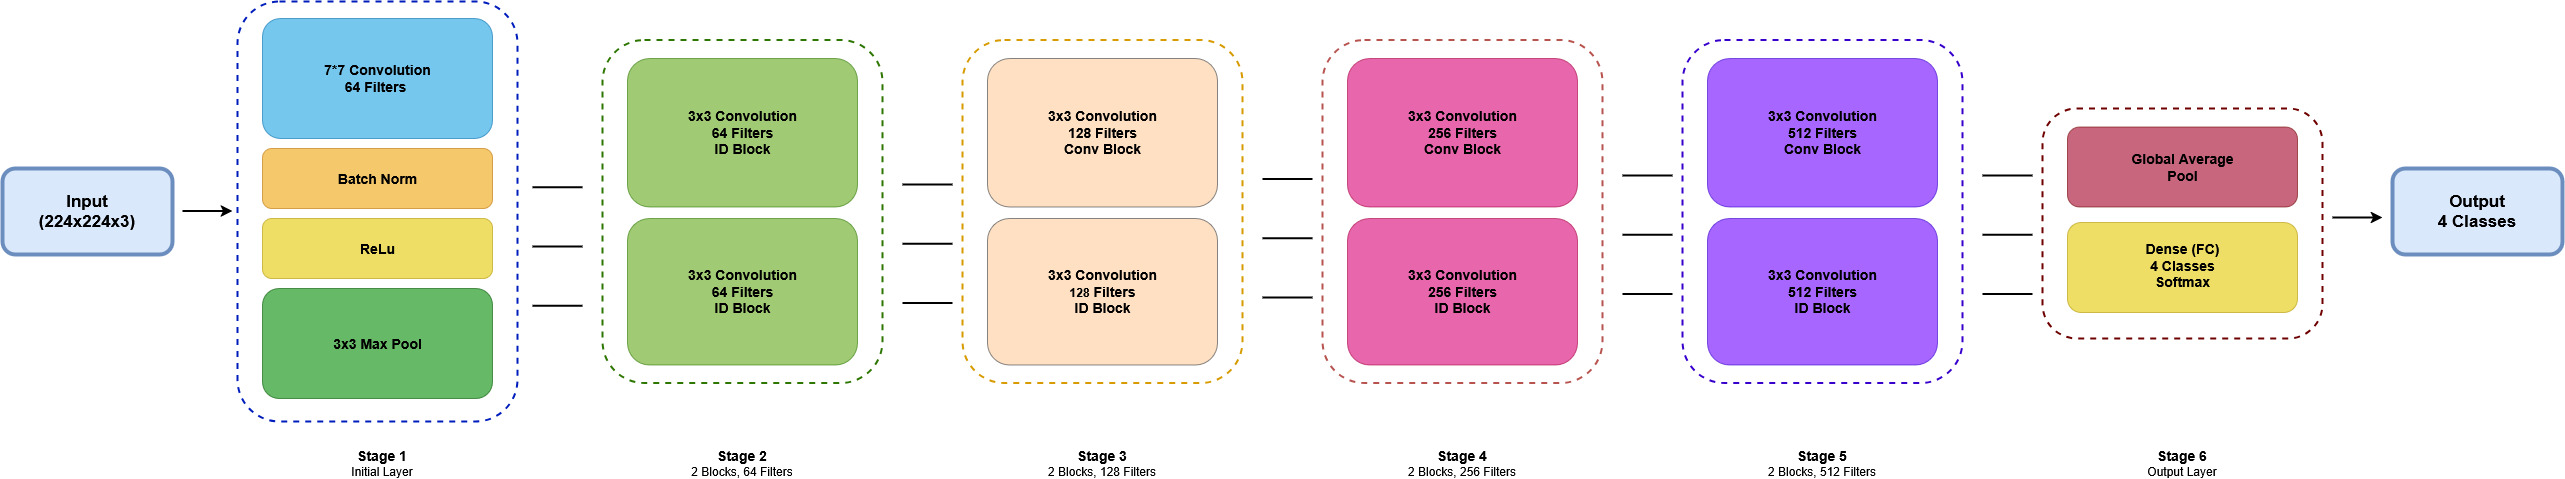

In [ ]:
class ResidualBlock(layers.Layer):

    def __init__(self, filters, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()

        self.conv2 = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()

        if stride != 1:
            self.shortcut = keras.Sequential([
                layers.Conv2D(filters, 1, strides=stride, use_bias=False),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x

        self.relu2 = layers.ReLU()

    def call(self, x, training=False):
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out, training=training)
        shortcut = self.shortcut(x)

        out = layers.Add()([out, shortcut])
        out = self.relu2(out)

        return out

def create_resnet18(num_classes=4, input_shape=(224, 224, 3)):

    inputs = keras.Input(shape=input_shape)

    # Stage 1 - Initial Layer
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Stage 2 - 64 filters
    x = ResidualBlock(64, stride=1)(x)
    x = ResidualBlock(64, stride=1)(x)

    # Stage 3 - 128 filters
    x = ResidualBlock(128, stride=2)(x)
    x = ResidualBlock(128, stride=1)(x)

    # Stage 4 - 256 filters
    x = ResidualBlock(256, stride=2)(x)
    x = ResidualBlock(256, stride=1)(x)

    # Stage 5 - 512 filters
    x = ResidualBlock(512, stride=2)(x)
    x = ResidualBlock(512, stride=1)(x)

    # Stage 6 - Output Layer
    x = layers.GlobalAveragePooling2D()(x)

    # Monte Carlo Dropout layer for uncertainty
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='resnet18')

    return model


MC Dropout Functions

In [ ]:
def mc_dropout_predict(model, x, num_samples=30):

    predictions = []
    for _ in range(num_samples):
        pred = model(x, training=True)
        predictions.append(pred.numpy())

    predictions = np.array(predictions)

    mean_pred = np.mean(predictions, axis=0)
    std_pred = np.std(predictions, axis=0)

    return predictions, mean_pred, std_pred

def calculate_predictive_entropy(predictions):

    epsilon = 1e-10
    predictions = np.clip(predictions, epsilon, 1 - epsilon)

    entropy = -np.sum(predictions * np.log(predictions), axis=1)

    return entropy

def evaluate_with_mc_dropout(model, dataset, num_mc_samples=30, class_names=['NC', 'G3', 'G4', 'G5']):

    y_true = []
    y_pred_mean = []
    y_pred_std = []
    y_pred_entropy = []
    all_mc_predictions = []

    batch_count = 0
    for images, labels in dataset:
        batch_count += 1
        print(f"Processing batch {batch_count}...", end='\r')

        # Get MC Dropout predictions
        mc_preds, mean_pred, std_pred = mc_dropout_predict(
            model, images, num_samples=num_mc_samples
        )

        # Calculate entropy
        entropy = calculate_predictive_entropy(mean_pred)

        y_true.extend(labels.numpy())
        y_pred_mean.extend(mean_pred)
        y_pred_std.extend(std_pred)
        y_pred_entropy.extend(entropy)
        all_mc_predictions.extend(mc_preds.transpose(1, 0, 2))

    y_true = np.array(y_true)
    y_pred_mean = np.array(y_pred_mean)
    y_pred_std = np.array(y_pred_std)
    y_pred_entropy = np.array(y_pred_entropy)
    y_pred_class = np.argmax(y_pred_mean, axis=1)

    # Calculate accuracy
    accuracy = np.mean(y_true == y_pred_class)
    print(f"\nValidation Accuracy (MC Dropout): {accuracy*100:.2f}%")

    return {
        'y_true': y_true,
        'y_pred_mean': y_pred_mean,
        'y_pred_class': y_pred_class,
        'y_pred_std': y_pred_std,
        'y_pred_entropy': y_pred_entropy,
        'all_mc_predictions': all_mc_predictions,
        'accuracy': accuracy
    }

def plot_uncertainty_analysis(results, class_names=['NC', 'G3', 'G4', 'G5'], save_path=None):

    y_true = results['y_true']
    y_pred_class = results['y_pred_class']
    y_pred_entropy = results['y_pred_entropy']
    y_pred_std = results['y_pred_std']

    # Determine correct vs incorrect predictions
    correct = y_true == y_pred_class

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Entropy distribution for correct vs incorrect predictions
    axes[0, 0].hist(y_pred_entropy[correct], bins=30, alpha=0.7, label='Correct', color='green')
    axes[0, 0].hist(y_pred_entropy[~correct], bins=30, alpha=0.7, label='Incorrect', color='red')
    axes[0, 0].set_xlabel('Predictive Entropy', fontsize=11)
    axes[0, 0].set_ylabel('Count', fontsize=11)
    axes[0, 0].set_title('Uncertainty Distribution: Correct vs Incorrect', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Mean uncertainty (std) per class
    mean_std_per_class = []
    for i in range(len(class_names)):
        class_mask = y_true == i
        if class_mask.sum() > 0:
            mean_std = np.mean(y_pred_std[class_mask].max(axis=1))
            mean_std_per_class.append(mean_std)
        else:
            mean_std_per_class.append(0)

    axes[0, 1].bar(class_names, mean_std_per_class, color='skyblue', edgecolor='black')
    axes[0, 1].set_xlabel('Class', fontsize=11)
    axes[0, 1].set_ylabel('Mean Uncertainty (Std)', fontsize=11)
    axes[0, 1].set_title('Average Uncertainty by Class', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # 3. Scatter: Confidence vs Entropy
    max_prob = np.max(results['y_pred_mean'], axis=1)
    colors = ['green' if c else 'red' for c in correct]
    axes[1, 0].scatter(max_prob, y_pred_entropy, c=colors, alpha=0.5, s=20)
    axes[1, 0].set_xlabel('Max Predicted Probability (Confidence)', fontsize=11)
    axes[1, 0].set_ylabel('Predictive Entropy (Uncertainty)', fontsize=11)
    axes[1, 0].set_title('Confidence vs Uncertainty', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)

    legend_elements = [Patch(facecolor='green', alpha=0.5, label='Correct'),
                      Patch(facecolor='red', alpha=0.5, label='Incorrect')]
    axes[1, 0].legend(handles=legend_elements)

    # 4. Uncertainty statistics
    axes[1, 1].axis('off')
    stats_text = f"""
    Uncertainty Statistics:

    Overall:
    • Mean Entropy: {np.mean(y_pred_entropy):.4f}
    • Std Entropy: {np.std(y_pred_entropy):.4f}

    Correct Predictions:
    • Mean Entropy: {np.mean(y_pred_entropy[correct]):.4f}
    • Count: {correct.sum()}

    Incorrect Predictions:
    • Mean Entropy: {np.mean(y_pred_entropy[~correct]):.4f}
    • Count: {(~correct).sum()}

    High Uncertainty Samples:
    • Samples with entropy > 1.0: {(y_pred_entropy > 1.0).sum()}
    • Accuracy on high uncertainty: {np.mean(correct[y_pred_entropy > 1.0])*100:.1f}%

    Low Uncertainty Samples:
    • Samples with entropy < 0.5: {(y_pred_entropy < 0.5).sum()}
    • Accuracy on low uncertainty: {np.mean(correct[y_pred_entropy < 0.5])*100:.1f}%
    """
    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center',
                    family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    return fig

Model Creation

In [ ]:
model = create_resnet18(num_classes=4)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "resnet18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 56, 56, 64)     │        74,240 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 28, 28, 128)    │       230,912 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 28, 28, 128)    │       295,936 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (None, 14, 14, 256)    │       920,576 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_5                │ (None, 14, 14, 256)    │     1,181,696 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_6                │ (None, 7, 7, 512)      │     3,676,160 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_7                │ (None, 7, 7, 512)      │     4,722,688 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,188,164 (42.68 MB)

 Trainable params: 11,178,564 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

# 5. Create Data Pipeline

In [ ]:
def create_dataset(data_dir, labels_csv, batch_size=32, shuffle=True, augment=False):
    df = pd.read_csv(labels_csv)
    data_dir = Path(data_dir)

    image_paths = [str(data_dir / 'images' / name) for name in df['image_name']]
    labels = df['label'].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = tf.cast(img, tf.float32) / 255.0

        # Data augmentation
        # This makes it harder for models to memorize and forces learning
        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_flip_up_down(img)
            k = tf.random.uniform([], 0, 4, dtype=tf.int32)
            img = tf.image.rot90(img, k=k)
            img = tf.image.random_brightness(img, max_delta=0.1)
            img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

        mean = tf.constant([0.485, 0.456, 0.406])
        std = tf.constant([0.229, 0.224, 0.225])
        img = (img - mean) / std
        return img, label

    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

train_dataset = create_dataset(
    '/content/organized_dataset/train',
    '/content/organized_dataset/train_labels.csv',
    batch_size=32,
    shuffle=True,
    augment=True
)

val_dataset = create_dataset(
    '/content/organized_dataset/val',
    '/content/organized_dataset/val_labels.csv',
    batch_size=32,
    shuffle=False,
    augment=False
)

print(f"Train samples: {len(pd.read_csv('/content/organized_dataset/train_labels.csv'))}")
print(f"Val samples: {len(pd.read_csv('/content/organized_dataset/val_labels.csv'))}")

Train samples: 8215
Val samples: 1744


# 6. Train Model

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-7
    )
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

model.save('/content/drive/MyDrive/Deep Learning - Project Group 10/project10_model.keras')

Epoch 1/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5622 - loss: 1.2526
Epoch 1: val_accuracy improved from -inf to 0.38647, saving model to best_model.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 87s 234ms/step - accuracy: 0.5626 - loss: 1.2514 - val_accuracy: 0.3865 - val_loss: 13.0407 - learning_rate: 1.0000e-04
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5550 - loss: 1.3658
Epoch 2: val_accuracy improved from 0.38647 to 0.56307, saving model to best_model.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 47s 167ms/step - accuracy: 0.5555 - loss: 1.3641 - val_accuracy: 0.5631 - val_loss: 1.3972 - learning_rate: 1.0000e-04
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5500 - loss: 1.4706
Epoch 3: val_accuracy did not improve from 0.56307
257/257 ━━━━━━━━━━━━━━━━━━━━ 86s 186ms/step - accuracy: 0.5505 - loss: 1.4686 - val_accuracy: 0.4042 - val_loss: 2.2563 - learning_rate: 1.0000e-04
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy:

# 7. Evaluation

Evaluating model on validation set...

Validation Accuracy: 61.41%


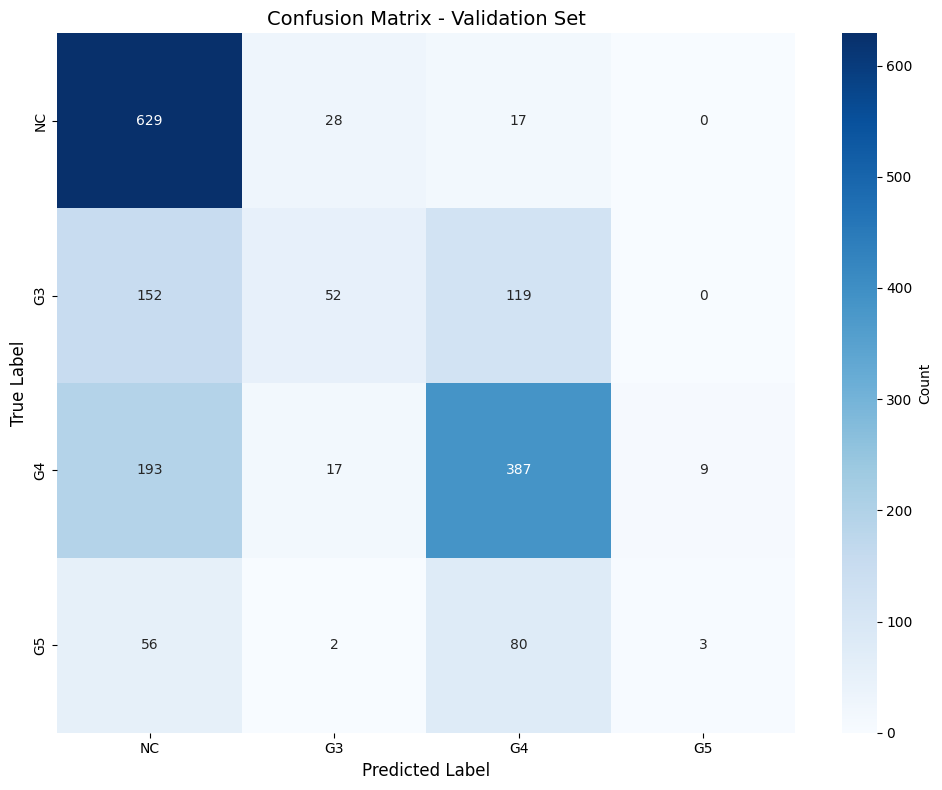


Confusion Matrix:
[[629  28  17   0]
 [152  52 119   0]
 [193  17 387   9]
 [ 56   2  80   3]]

Per-class statistics:

NC:
  Precision: 0.611
  Recall: 0.933
  F1-Score: 0.738
  Support: 674

G3:
  Precision: 0.525
  Recall: 0.161
  F1-Score: 0.246
  Support: 323

G4:
  Precision: 0.642
  Recall: 0.639
  F1-Score: 0.640
  Support: 606

G5:
  Precision: 0.250
  Recall: 0.021
  F1-Score: 0.039
  Support: 141

AUC Scores (One-vs-Rest):
NC: 0.902
G3: 0.761
G4: 0.829
G5: 0.541

Macro-Average AUC: 0.758


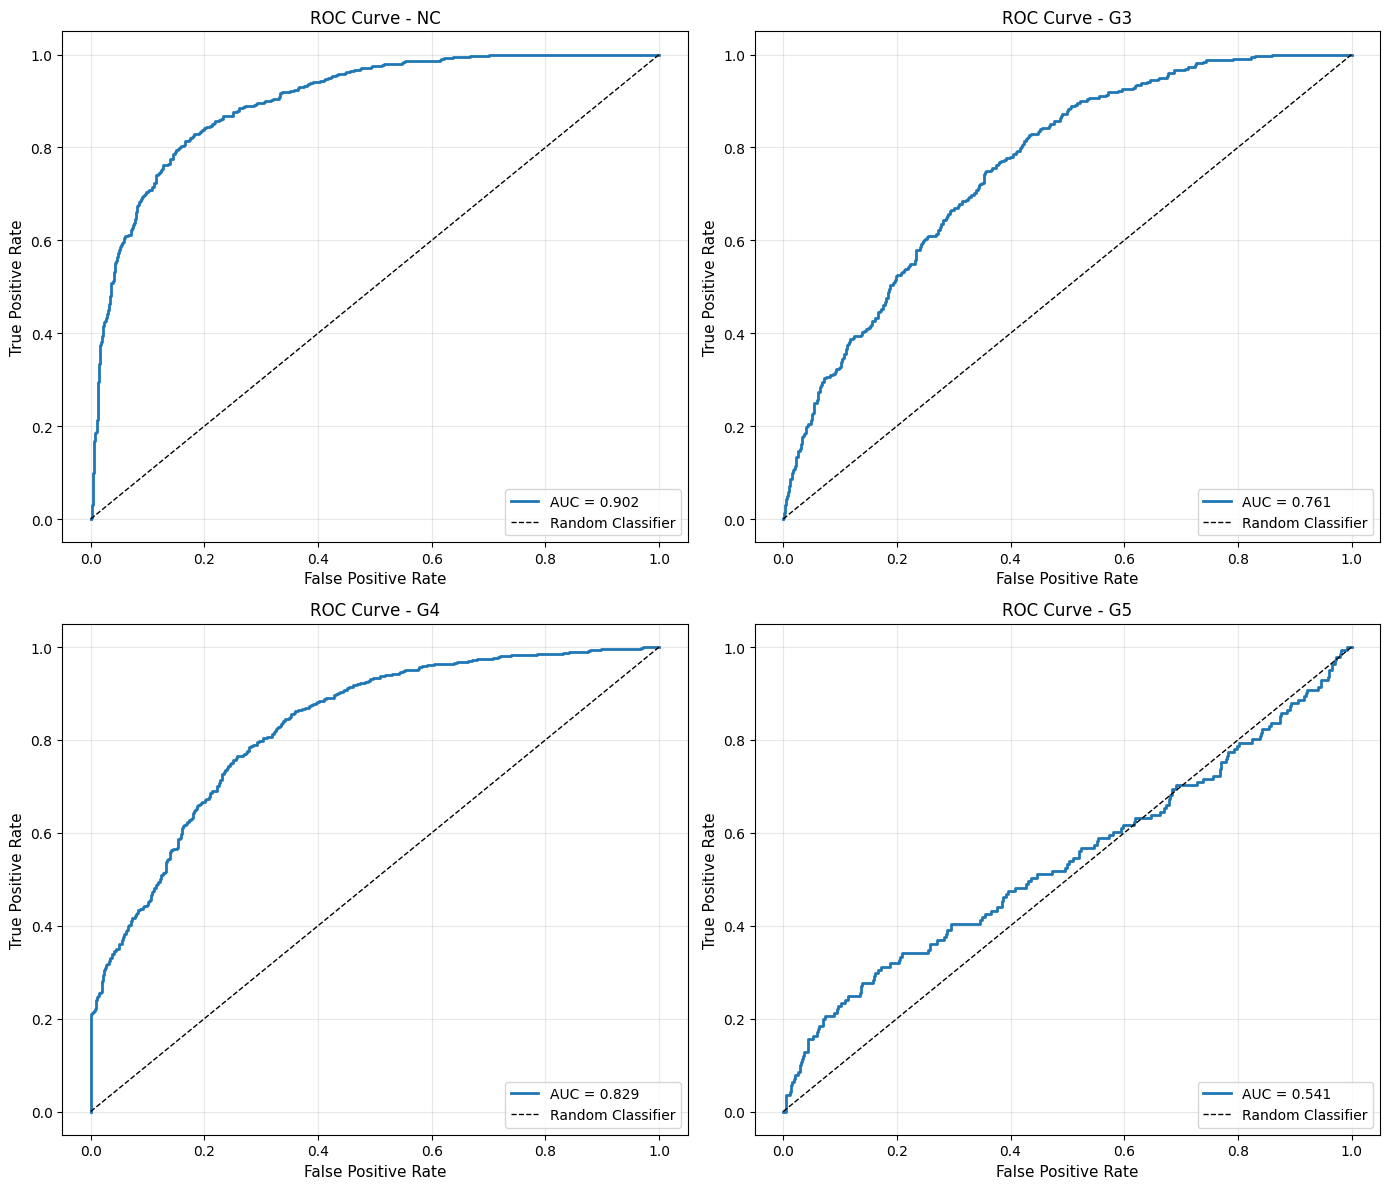


EVALUATION SUMMARY
Overall Accuracy: 61.41%
Macro-Average AUC: 0.758

Per-Class AUC Scores:
  NC: 0.902
  G3: 0.761
  G4: 0.829
  G5: 0.541


In [ ]:

# ============================================
# 1. Get predictions on validation set
# ============================================
print("Evaluating model on validation set...")

# Get all predictions and true labels
y_true = []
y_pred = []
y_pred_proba = []

for images, labels in val_dataset:
    predictions = model.predict(images, verbose=0)
    y_pred_proba.extend(predictions)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# ============================================
# 2. Calculate Accuracy
# ============================================
accuracy = np.mean(y_true == y_pred)
print(f"\nValidation Accuracy: {accuracy*100:.2f}%")

# ============================================
# 3. Confusion Matrix
# ============================================
class_names = ['NC', 'G3', 'G4', 'G5']
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Validation Set', fontsize=14)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep Learning - Project Group 10/confusion_matrix.png',
            dpi=150, bbox_inches='tight')
plt.show()

# Print confusion matrix statistics
print("\nConfusion Matrix:")
print(cm)
print("\nPer-class statistics:")
for i, class_name in enumerate(class_names):
    true_positives = cm[i, i]
    false_positives = cm[:, i].sum() - true_positives
    false_negatives = cm[i, :].sum() - true_positives
    true_negatives = cm.sum() - (true_positives + false_positives + false_negatives)

    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{class_name}:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}")
    print(f"  Support: {cm[i, :].sum()}")

# ============================================
# 4. AUC per Class (One-vs-Rest)
# ============================================
print("\n" + "="*50)
print("AUC Scores (One-vs-Rest):")
print("="*50)

# Binarize labels for multi-class AUC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

# Calculate AUC for each class
auc_scores = {}
for i, class_name in enumerate(class_names):
    try:
        auc_score = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
        auc_scores[class_name] = auc_score
        print(f"{class_name}: {auc_score:.3f}")
    except ValueError:
        print(f"{class_name}: Unable to calculate (class may not be in validation set)")
        auc_scores[class_name] = None

# Calculate macro-average AUC
valid_aucs = [v for v in auc_scores.values() if v is not None]
macro_auc = np.mean(valid_aucs) if valid_aucs else 0
print(f"\nMacro-Average AUC: {macro_auc:.3f}")

# ============================================
# 5. Plot ROC Curves
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    if auc_scores[class_name] is not None:
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])

        axes[i].plot(fpr, tpr, linewidth=2,
                    label=f'AUC = {auc_scores[class_name]:.3f}')
        axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        axes[i].set_xlabel('False Positive Rate', fontsize=11)
        axes[i].set_ylabel('True Positive Rate', fontsize=11)
        axes[i].set_title(f'ROC Curve - {class_name}', fontsize=12)
        axes[i].legend(loc='lower right', fontsize=10)
        axes[i].grid(True, alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'No data for {class_name}',
                    ha='center', va='center', fontsize=12)
        axes[i].set_title(f'ROC Curve - {class_name}', fontsize=12)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep Learning - Project Group 10/roc_curves.png',
            dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# 6. Summary Report
# ============================================
print("\n" + "="*50)
print("EVALUATION SUMMARY")
print("="*50)
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Macro-Average AUC: {macro_auc:.3f}")
print(f"\nPer-Class AUC Scores:")
for class_name, auc_val in auc_scores.items():
    if auc_val is not None:
        print(f"  {class_name}: {auc_val:.3f}")

# 8. Monte Carlo Dropout Analysis

MONTE CARLO DROPOUT UNCERTAINTY ESTIMATION
Performing MC Dropout evaluation with 30 samples...

MC Dropout evaluation complete!

Validation Accuracy (MC Dropout): 38.70%


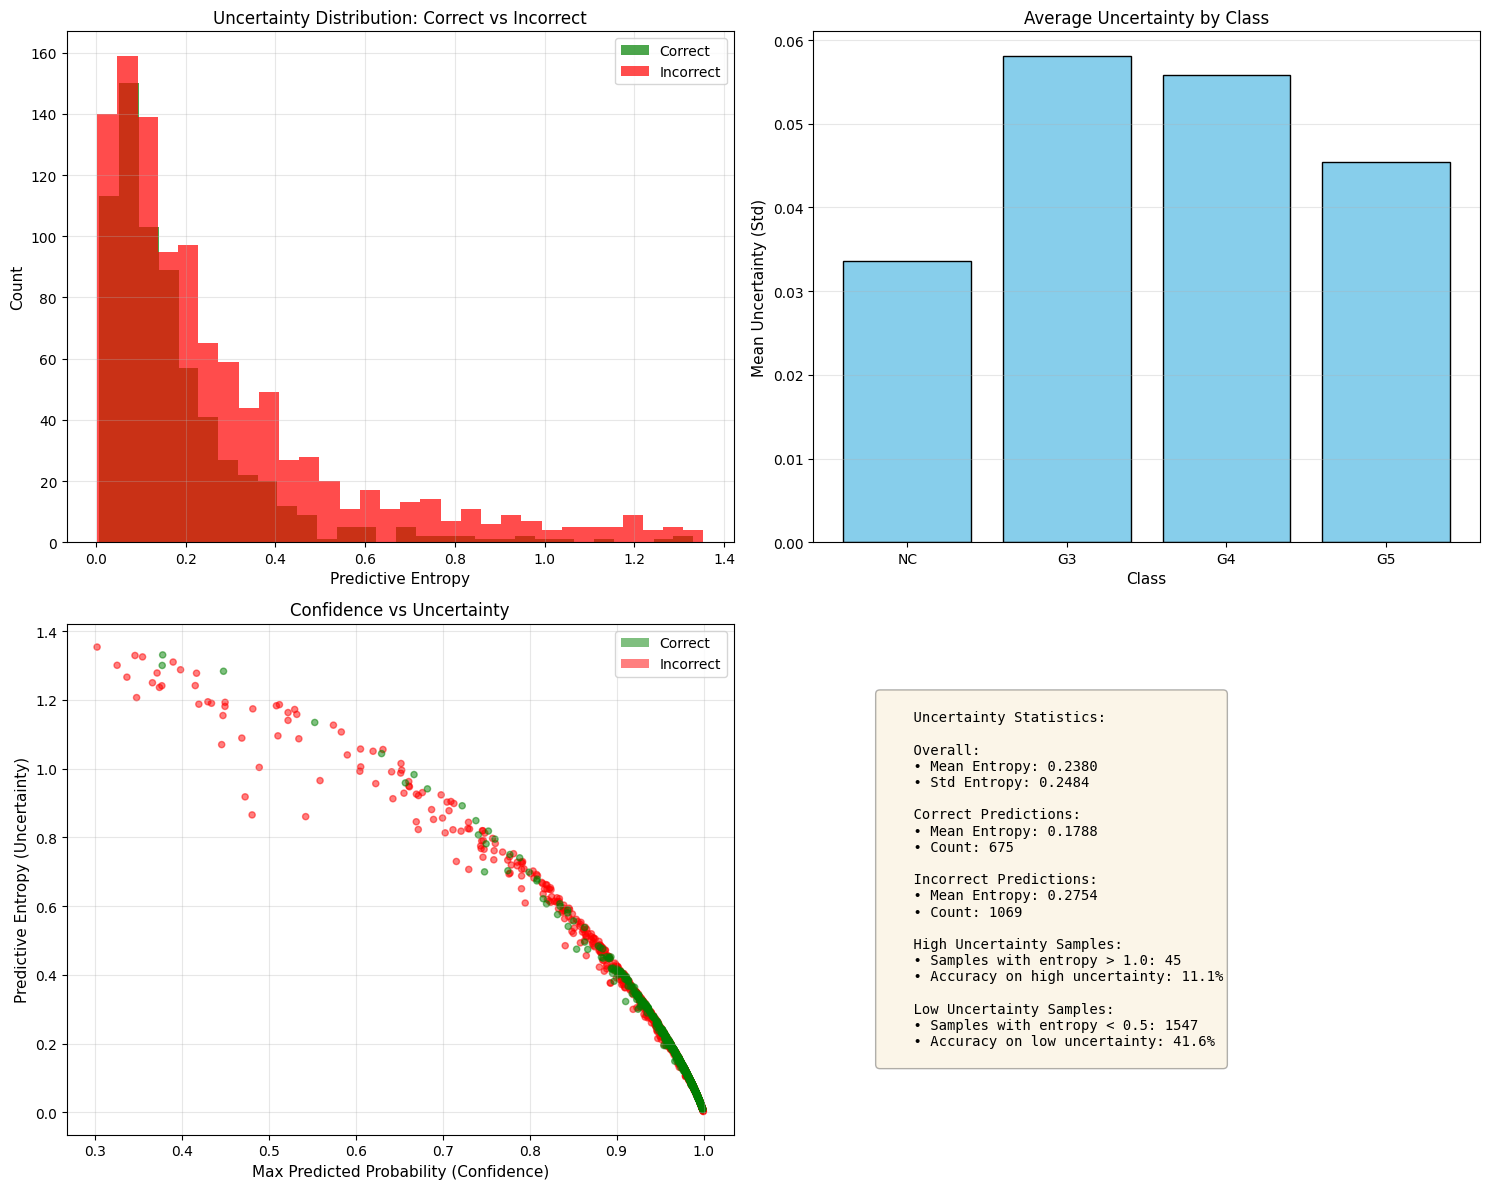

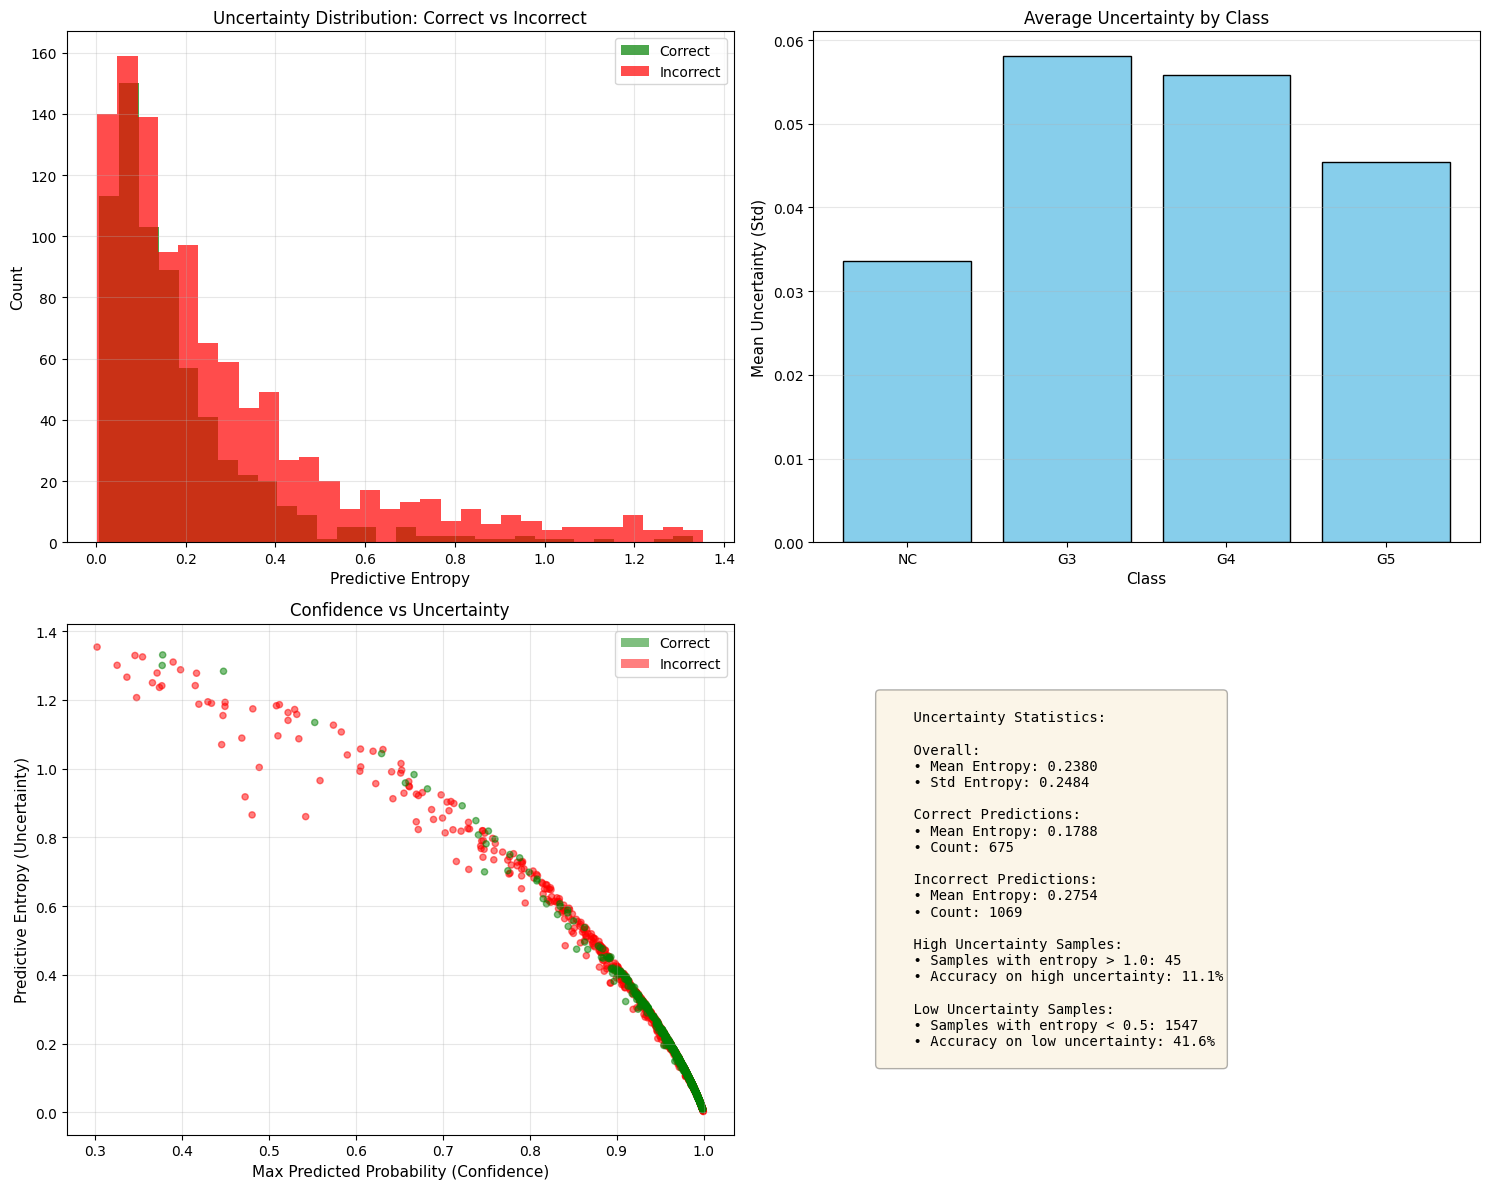

In [ ]:
print("MONTE CARLO DROPOUT UNCERTAINTY ESTIMATION")

mc_results = evaluate_with_mc_dropout(
    model,
    val_dataset,
    num_mc_samples=30,
    class_names=['NC', 'G3', 'G4', 'G5']
)

plot_uncertainty_analysis(
    mc_results,
    class_names=['NC', 'G3', 'G4', 'G5'],
    save_path='/content/drive/MyDrive/Deep Learning - Project Group 10/uncertainty_analysis.png'
)

# 9. Calibration (Weighted ensemble based on Brier Score Loss)

In [ ]:
# Define Temperature Scaler
class TemperatureScaler(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.temperature = self.add_weight(name="temp", shape = (), initializer = tf.keras.initializers.Constant(1.0), trainable = True)

  def call(self, logits):
    return logits / self.temperature

# Logits converter
eps = 1e-8
logits = tf.math.log(y_pred_proba + eps)

# Define Temperature Scale Fitter
def fit_temperature_multi(logits, y_true, lr = 0.01, epochs = 200):
  ts = TemperatureScaler()

  _ = ts(logits[:1])

  optimize = tf.keras.optimizers.Adam(learning_rate = lr)
  y_true_tensor = tf.convert_to_tensor(y_true, dtype = tf.int32)

  N, C = logits.shape

  for e in range(epochs):
    with tf.GradientTape() as tape:
      scaled_logits = ts(logits)
      probs = tf.nn.softmax(scaled_logits, axis=1)

      # One-hot encode y_true
      y_onehot = tf.one_hot(y_true_tensor, depth=C, dtype=tf.float32)

      # Multiclass Brier score
      loss = tf.reduce_mean(tf.reduce_sum((probs - y_onehot) ** 2, axis=1))

    grad = tape.gradient(loss, ts.trainable_variables)
    optimize.apply_gradients(zip(grad, ts.trainable_variables))

  return ts.temperature.numpy()

# Fit Scaler to Model
temperature = fit_temperature_multi(logits, y_true)

# Apply Temperature
logits_scaled = logits / temperature
prob_temp = tf.nn.softmax(logits_scaled).numpy()

# Define histogram binning
def histogram_bin_multi(y_true, probs, bins = 10):
  N, C = probs.shape
  calibrated = np.zeros_like(probs)

  for c in range(C):
    prob = probs[:, c]
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_ids = np.digitize(prob, bin_edges) - 1
    bin_ids = np.clip(bin_ids, 0, bins - 1)

    y_c = (y_true == c).astype(float)

    bin_sums = np.bincount(bin_ids, weights=y_c, minlength=bins)
    bin_total = np.bincount(bin_ids, minlength=bins)

    bin_avg = np.zeros(bins)
    nonzero = bin_total > 0
    bin_avg[nonzero] = bin_sums[nonzero] / bin_total[nonzero]

    calibrated[:, c] = bin_avg[bin_ids]

  calibrated /= calibrated.sum(axis = 1, keepdims = True)

  return calibrated

# Apply histogram binning
prob_hist = histogram_bin_multi(y_true, y_pred_proba, bins = 10)

# Define Isotonic Regression
def isotonic_multi(y_true, probs):
  N, C = probs.shape
  calibrated = np.zeros_like(probs)

  for c in range(C):
    iso = IsotonicRegression(out_of_bounds = "clip")
    calibrated[:, c] = iso.fit_transform(probs[:, c], (y_true == c).astype(float))

  calibrated /= calibrated.sum(axis = 1, keepdims = True)
  return calibrated

# Apply Isotonic Regression
prob_iso = isotonic_multi(y_true, y_pred_proba)

# Define ECE function
def ECE_multi(y_true, probs, bins = 15):
  N, C = probs.shape
  confidences = np.max(probs, axis = 1)
  predictions = np.argmax(probs, axis = 1)

  accuracies = (predictions == y_true).astype(float)

  bin_edges = np.linspace(0, 1, bins + 1)
  ece = 0

  for i in range (bins):
    start, end = bin_edges[i], bin_edges[i + 1]
    mask = (confidences >= start) & (confidences < end)

    if mask.sum() > 0:
      avg_conf = confidences[mask].mean()
      avg_acc = accuracies[mask].mean()
      ece += np.abs(avg_conf - avg_acc) * mask.sum() / N

  return ece

# Verify Probabilities
def check_probs(name, probs):
    assert probs.ndim == 2, f"{name} is not (N, C)"
    assert np.allclose(probs.sum(axis=1), 1.0, atol=1e-5), \
        f"{name} probabilities do not sum to 1"

check_probs("Base", y_pred_proba)
check_probs("Temperature", prob_temp)
check_probs("Histogram", prob_hist)
check_probs("Isotonic", prob_iso)

# Multiclass Brier score
def brier_score_multi(y_true, probs):
    N, C = probs.shape
    y_onehot = np.zeros_like(probs)
    y_onehot[np.arange(N), y_true] = 1
    return np.mean(np.sum((probs - y_onehot) ** 2, axis=1))

# Weighted ensemble by minimized Brier score
def ensemble_loss_func_brier(weights, y_true, prob_list):
    weights = np.array(weights)

    # Weighted sum
    prob_ens = np.zeros_like(prob_list[0])
    for w, p in zip(weights, prob_list):
        prob_ens += w * p

    # Normalize
    prob_ens = np.clip(prob_ens, 1e-15, 1.0)
    prob_ens /= prob_ens.sum(axis=1, keepdims=True)

    return brier_score_multi(y_true, prob_ens)

# Optimize weights
prob_list = [y_pred_proba, prob_temp, prob_hist, prob_iso]
K = len(prob_list)
init_weights = np.ones(K) / K
bounds = [(0.0, 1.0)] * K
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

result = opt.minimize(ensemble_loss_func_brier, init_weights, args=(y_true, prob_list),
                      method="SLSQP", bounds=bounds, constraints=constraints)

best_weights = result.x

# Apply new weights
prob_weighted_ensemble = np.zeros_like(y_pred_proba)
for w, p in zip(best_weights, prob_list):
    prob_weighted_ensemble += w * p

prob_weighted_ensemble = np.clip(prob_weighted_ensemble, 1e-15, 1.0)
prob_weighted_ensemble /= prob_weighted_ensemble.sum(axis=1, keepdims=True)

# Select best model based on Brier score
models = {"Base": y_pred_proba, "Temperature Scaled": prob_temp, "Histogram Binned": prob_hist, "Isotonic Regressed": prob_iso, "Weighted Ensemble": prob_weighted_ensemble}

best_model = min(models, key=lambda m: brier_score_multi(y_true, models[m]))
print("Best model based on Brier score: ", best_model)

Best model based on Brier score:  Isotonic Regressed


## 9.1 Comparison of Calibration Metrics

                Model  Brier Score       ECE
0                Base     0.541784  0.132531
1  Temperature Scaled     0.530695  0.122812
2    Histogram Binned     0.460470  0.049211
3  Isotonic Regressed     0.443143  0.035217
4   Weighted Ensemble     0.475110  0.062944


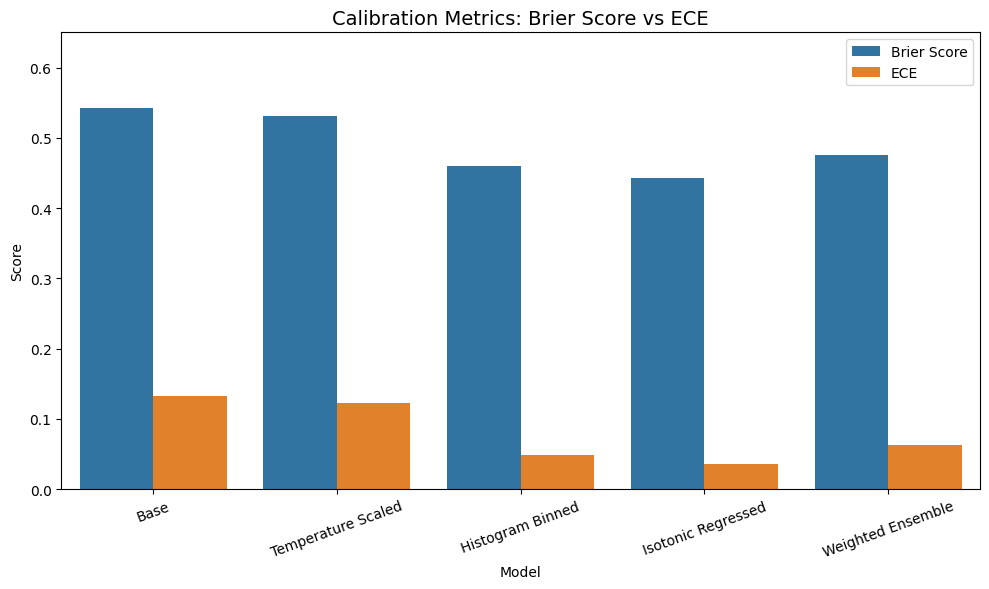

In [ ]:
# Calculate Brier and ECE Scores
brier_scores = []
ece_scores = []

for name, prob in models.items():
    brier_scores.append(brier_score_multi(y_true, prob))
    ece_scores.append(ECE_multi(y_true, prob))

# Create DataFrames
df_metrics = pd.DataFrame({
    'Model': list(models.keys()),
    'Brier Score': brier_scores,
    'ECE': ece_scores
})
print(df_metrics)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y = 'value', hue = 'variable', data = pd.melt(df_metrics, id_vars = 'Model', value_vars = ['Brier Score', 'ECE']))
plt.title("Calibration Metrics: Brier Score vs ECE", fontsize=14)
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, max(max(brier_scores), max(ece_scores)) * 1.2)
plt.xticks(rotation=20)
plt.legend(title='')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep Learning - Project Group 10/calibration_metrics.png', dpi = 150, bbox_inches ='tight')
plt.show()

## 9.2 Calibrated Model Evaluations (Isotonic Regression)


Validation Accuracy of Isotonic Regressed: 64.62%


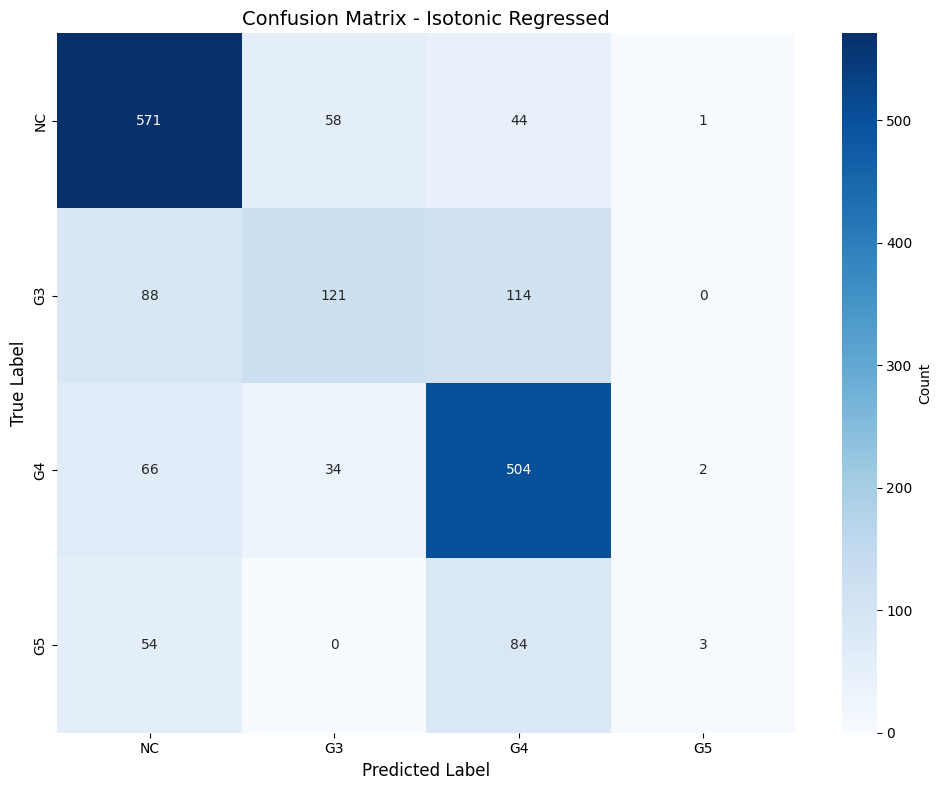


Per Class Statistics
NC: Precision = 0.733, Recall = 0.847, F1-Score=0.786, Support = 674
G3: Precision = 0.568, Recall = 0.375, F1-Score=0.451, Support = 323
G4: Precision = 0.676, Recall = 0.832, F1-Score=0.746, Support = 606
G5: Precision = 0.500, Recall = 0.021, F1-Score=0.041, Support = 141


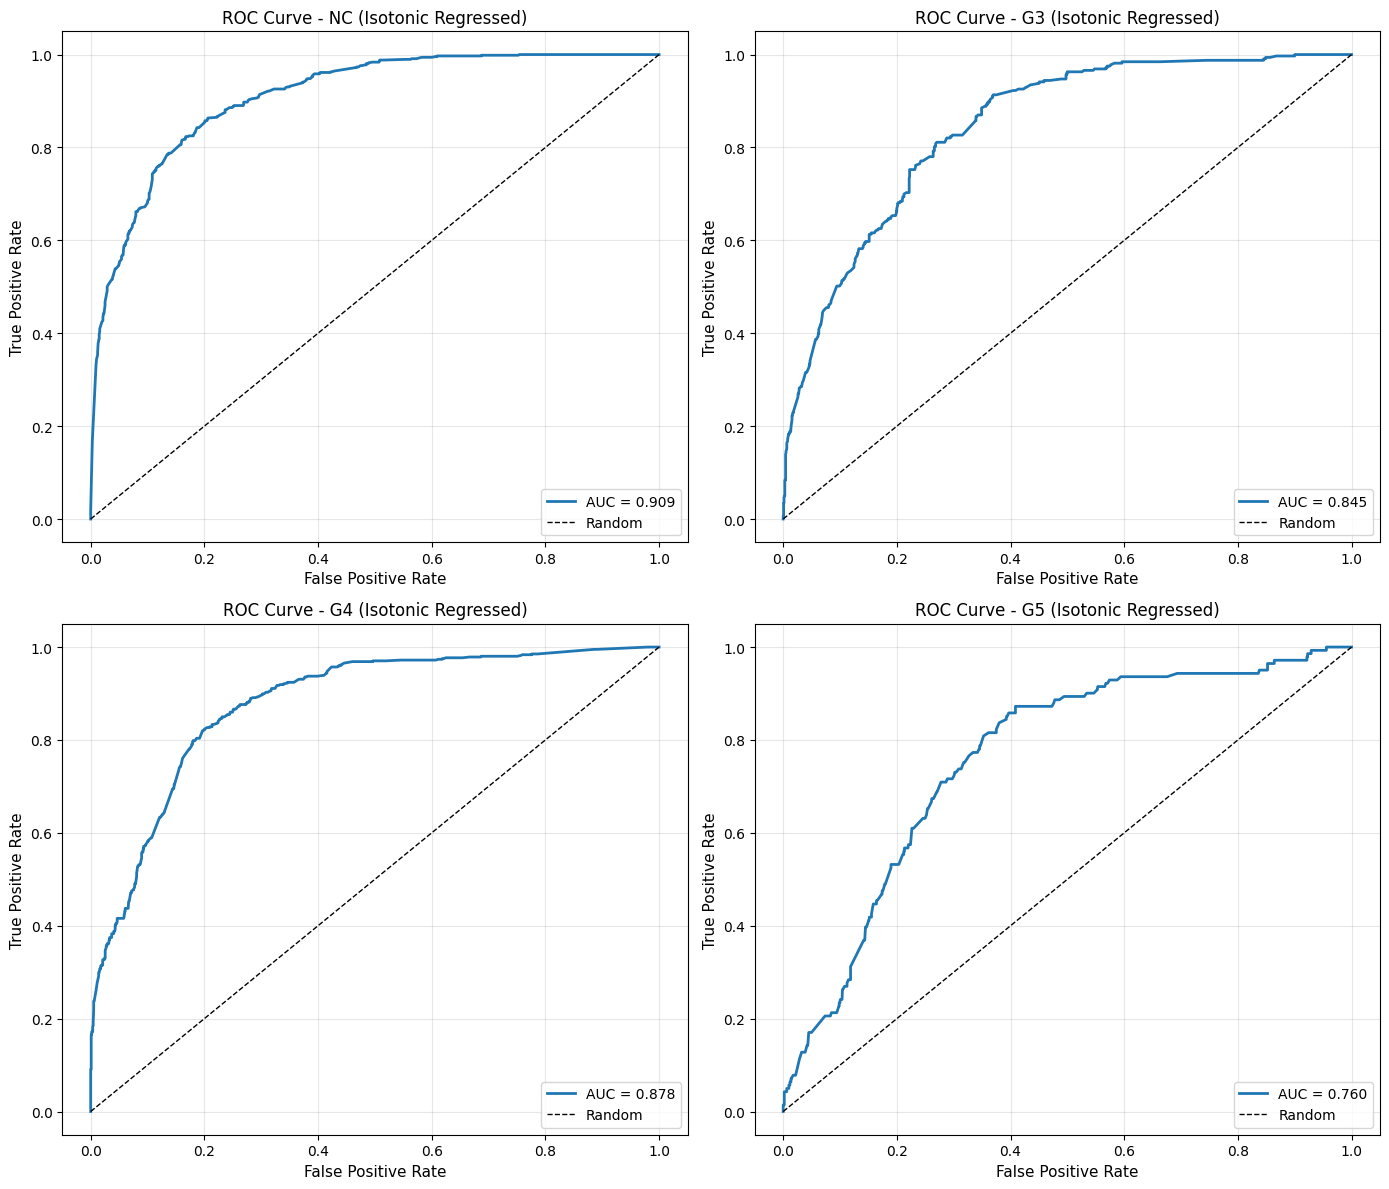


Brier Score (Isotonic Regressed): 0.4431
ECE (Isotonic Regressed): 0.0352

EVALUATION SUMMARY - Isotonic Regressed
Overall Accuracy: 64.62%
Macro-Average AUC: 0.848
Brier Score: 0.4431
Expected Calibration Error (ECE): 0.0352

Per-Class AUC Scores:
  NC: 0.909
  G3: 0.845
  G4: 0.878
  G5: 0.760


In [ ]:
# Define Model Classes
best_probs = models[best_model]

y_pred_c = np.argmax(best_probs, axis = 1)

#======================================================
# 1. Accuracy
#======================================================
accuracy_c = np.mean(y_true == y_pred_c)
print(f"\nValidation Accuracy of {best_model}: {accuracy*100:.2f}%")

#======================================================
# 2. Confusion Matrix
#======================================================
class_names = ['NC', 'G3', 'G4', 'G5']
cm = confusion_matrix(y_true, y_pred_c)

plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names, cbar_kws = {'label': 'Count'})
plt.xlabel('Predicted Label', fontsize = 12)
plt.ylabel('True Label', fontsize = 12)
plt.title(f'Confusion Matrix - {best_model}', fontsize = 14)
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/Deep Learning - Project Group 10/confusion_matrix_{best_model}.png', dpi = 150, bbox_inches = 'tight')
plt.show()

print("\nPer Class Statistics")
for i, class_name in enumerate(class_names):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"{class_name}: Precision = {precision:.3f}, Recall = {recall:.3f}, F1-Score={f1:.3f}, Support = {cm[i, :].sum()}")

#======================================================
# 3. ROC Curve & AUC per Class
#======================================================
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

auc_scores_c = {}
for i, class_name in enumerate(class_names):
    try:
        auc_score = roc_auc_score(y_true_bin[:, i], best_probs[:, i])
        auc_scores_c[class_name] = auc_score
    except ValueError:
        auc_scores_c[class_name] = None

macro_auc = np.mean([v for v in auc_scores_c.values() if v is not None])

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    if auc_scores_c[class_name] is not None:
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], best_probs[:, i])
        axes[i].plot(fpr, tpr, linewidth = 2, label=f'AUC = {auc_scores_c[class_name]:.3f}')
        axes[i].plot([0,1], [0,1], 'k--', linewidth = 1, label = 'Random')
        axes[i].set_xlabel('False Positive Rate', fontsize = 11)
        axes[i].set_ylabel('True Positive Rate', fontsize = 11)
        axes[i].set_title(f'ROC Curve - {class_name} ({best_model})', fontsize = 12)
        axes[i].legend(loc = 'lower right', fontsize = 10)
        axes[i].grid(True, alpha = 0.3)
    else:
        axes[i].text(0.5, 0.5, f'No data for {class_name}', ha = 'center', va = 'center', fontsize = 12)
        axes[i].set_title(f'ROC Curve - {class_name} ({best_model})', fontsize = 12)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/Deep Learning - Project Group 10/roc_curves_{best_model}.png', dpi = 150, bbox_inches = 'tight')
plt.show()

#======================================================
# 4. Calibration: Brier Score & ECE
#======================================================
brier_score = brier_score_multi(y_true, best_probs)
ece_score = ECE_multi(y_true, best_probs)
print(f"\nBrier Score ({best_model}): {brier_score:.4f}")
print(f"ECE ({best_model}): {ece_score:.4f}")

#======================================================
# 5. Summary
#======================================================
print("\n" + "="*50)
print(f"EVALUATION SUMMARY - {best_model}")
print("="*50)
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Macro-Average AUC: {macro_auc:.3f}")
print(f"Brier Score: {brier_score:.4f}")
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")
print(f"\nPer-Class AUC Scores:")
for class_name, auc_val in auc_scores_c.items():
    if auc_val is not None:
        print(f"  {class_name}: {auc_val:.3f}")

## 9.3 Calibrated Model Evaluations (Temperature Scaled)


Validation Accuracy of Temperature Scaled: 64.62%


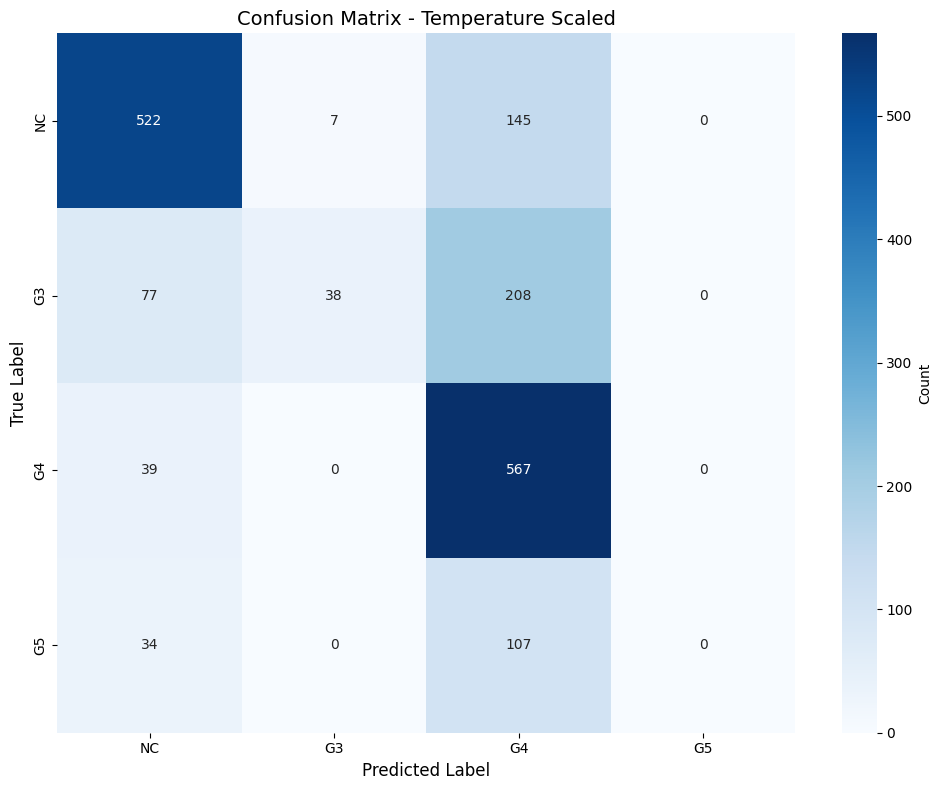


Per Class Statistics
NC: Precision = 0.777, Recall = 0.774, F1-Score=0.776, Support = 674
G3: Precision = 0.844, Recall = 0.118, F1-Score=0.207, Support = 323
G4: Precision = 0.552, Recall = 0.936, F1-Score=0.694, Support = 606
G5: Precision = 0.000, Recall = 0.000, F1-Score=0.000, Support = 141


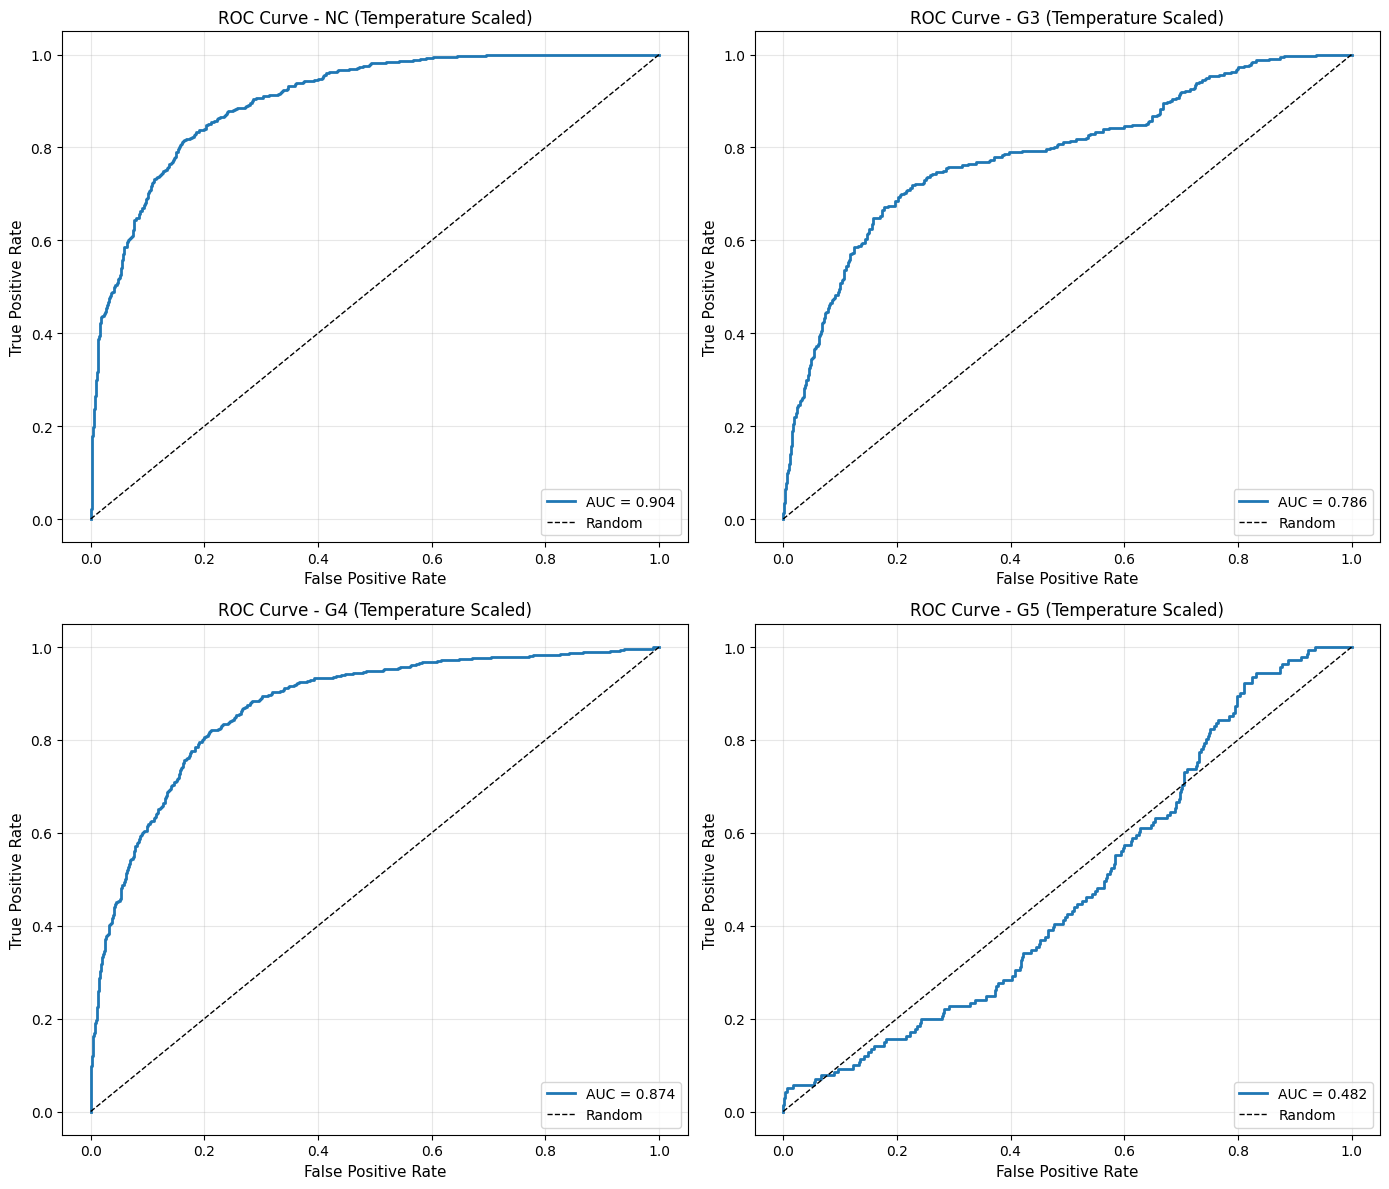


Brier Score (Temperature Scaled): 0.5307
ECE (Temperature Scaled): 0.1228

EVALUATION SUMMARY - Temperature Scaled
Overall Accuracy: 64.62%
Macro-Average AUC: 0.762
Brier Score: 0.5307
Expected Calibration Error (ECE): 0.1228

Per-Class AUC Scores:
  NC: 0.904
  G3: 0.786
  G4: 0.874
  G5: 0.482


In [ ]:
# Define Model Classes
best_model = "Temperature Scaled"
best_probs = models[best_model]

y_pred_c = np.argmax(best_probs, axis = 1)

#======================================================
# 1. Accuracy
#======================================================
accuracy_c = np.mean(y_true == y_pred_c)
print(f"\nValidation Accuracy of {best_model}: {accuracy*100:.2f}%")

#======================================================
# 2. Confusion Matrix
#======================================================
class_names = ['NC', 'G3', 'G4', 'G5']
cm = confusion_matrix(y_true, y_pred_c)

plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names, cbar_kws = {'label': 'Count'})
plt.xlabel('Predicted Label', fontsize = 12)
plt.ylabel('True Label', fontsize = 12)
plt.title(f'Confusion Matrix - {best_model}', fontsize = 14)
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/Deep Learning - Project Group 10/confusion_matrix_{best_model}.png', dpi = 150, bbox_inches = 'tight')
plt.show()

print("\nPer Class Statistics")
for i, class_name in enumerate(class_names):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"{class_name}: Precision = {precision:.3f}, Recall = {recall:.3f}, F1-Score={f1:.3f}, Support = {cm[i, :].sum()}")

#======================================================
# 3. ROC Curve & AUC per Class
#======================================================
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

auc_scores_c = {}
for i, class_name in enumerate(class_names):
    try:
        auc_score = roc_auc_score(y_true_bin[:, i], best_probs[:, i])
        auc_scores_c[class_name] = auc_score
    except ValueError:
        auc_scores_c[class_name] = None

macro_auc = np.mean([v for v in auc_scores_c.values() if v is not None])

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    if auc_scores_c[class_name] is not None:
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], best_probs[:, i])
        axes[i].plot(fpr, tpr, linewidth = 2, label=f'AUC = {auc_scores_c[class_name]:.3f}')
        axes[i].plot([0,1], [0,1], 'k--', linewidth = 1, label = 'Random')
        axes[i].set_xlabel('False Positive Rate', fontsize = 11)
        axes[i].set_ylabel('True Positive Rate', fontsize = 11)
        axes[i].set_title(f'ROC Curve - {class_name} ({best_model})', fontsize = 12)
        axes[i].legend(loc = 'lower right', fontsize = 10)
        axes[i].grid(True, alpha = 0.3)
    else:
        axes[i].text(0.5, 0.5, f'No data for {class_name}', ha = 'center', va = 'center', fontsize = 12)
        axes[i].set_title(f'ROC Curve - {class_name} ({best_model})', fontsize = 12)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/Deep Learning - Project Group 10/roc_curves_{best_model}.png', dpi = 150, bbox_inches = 'tight')
plt.show()

#======================================================
# 4. Calibration: Brier Score & ECE
#======================================================
brier_score = brier_score_multi(y_true, best_probs)
ece_score = ECE_multi(y_true, best_probs)
print(f"\nBrier Score ({best_model}): {brier_score:.4f}")
print(f"ECE ({best_model}): {ece_score:.4f}")

#======================================================
# 5. Summary
#======================================================
print("\n" + "="*50)
print(f"EVALUATION SUMMARY - {best_model}")
print("="*50)
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Macro-Average AUC: {macro_auc:.3f}")
print(f"Brier Score: {brier_score:.4f}")
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")
print(f"\nPer-Class AUC Scores:")
for class_name, auc_val in auc_scores_c.items():
    if auc_val is not None:
        print(f"  {class_name}: {auc_val:.3f}")